# Gradient based methods for machine learning

\begin{exercise}
Apply the following gradient based algorithms to estimate the minimum of the function 

    def Rosen(x,a=10):
        return (1-x[0])**2 + a*(x[1]-x[0]**2)**2
    def dRosen(x,a=10):
        return np.array([-2.0*(1.0-x[0]) - 2.0*a*(x[1]-x[0]**2)*2.0*x[0],2.0*a*(x[1]-x[0]**2)])
by following the example below. Given the same starting point evaluate the methods in terms of the number of iterations they take to compute an estimate to the minimum. Study the book "optimization for machine learning"
\end{exercise}

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from itertools import zip_longest

In [2]:
def Rosen(x,a=10):
    return (1-x[0])**2 + a*(x[1]-x[0]**2)**2
def dRosen(x,a=10):
    return np.array([-2.0*(1.0-x[0]) - 4.0*10*(x[1]-x[0]**2)*x[0],2.0*10*(x[1]-x[0]**2)])

In [3]:
x0=[7,6]
print(dRosen(x0))
print(Rosen(x0))

[12052.  -860.]
18526


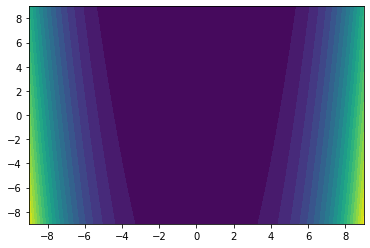

In [4]:
# plots the function
xi = np.linspace(-9, 9, 1000)
yi = np.linspace(-9, 9, 1000)
X,Y = np.meshgrid(xi, yi)
Z =  Rosen([X,Y],a=10)

def contour(X,Y,Z, arr = None):
    xx = X.flatten()
    yy = Y.flatten()
    zz = Z.flatten()
    plt.contourf(X, Y, Z, 20, cmap=plt.get_cmap('viridis'))
    if arr is not None:
        arr = np.array(arr)
        for i in range(len(arr) - 1):
            plt.xlim(-9, 9)
            plt.ylim(-9, 9)
            plt.plot(arr[i:i+2,0],arr[i:i+2,1], color='white')
        
contour(X,Y,Z)

In [5]:
def gd(x_start, step, gradient, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    for i in range(iteration):
        
        grad = gradient(x)
        #print(i,x,grad)
        x -= grad * step
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [6]:
def momentum(x_start, step, g, discount=0.7, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    for _ in range(iteration):
        grad = g(x)
        pre_grad = pre_grad * discount + grad
        x -= pre_grad * step
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [7]:
def nesterov(x_start, step, gradient, discount=0.7, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    for _ in range(iteration):
        x_future = x - step * discount * pre_grad
        grad = gradient(x_future)
        pre_grad = pre_grad * 0.7 + grad 
        x -= pre_grad * step
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [8]:
def adagrad(x_start, step, gradient, delta=1e-8, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    sum_grad = np.zeros_like(x)
    for _ in range(iteration):
        grad = gradient(x)
        sum_grad += grad * grad
        x -= step * grad / (np.sqrt(sum_grad) + delta)
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [9]:
def adadelta(x_start, step, gradient, momentum=0.9, delta=1e-1, iteration=50):
    x = np.array(x_start, dtype='float64')
    sum_grad = np.zeros_like(x)
    sum_diff = np.zeros_like(x)
    passing_dot = [x.copy()]
    for _ in range(iteration):
        grad = gradient(x)
        sum_grad = momentum * sum_grad + (1 - momentum) * grad * grad
        diff = np.sqrt((sum_diff + delta) / (sum_grad + delta)) * grad
        x -= step * diff
        sum_diff = momentum * sum_diff + (1 - momentum) * (diff * diff)
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [10]:
def rmsprop(x_start, step, gradient, rms_decay=0.9, delta=1e-8, iteration=50):
    x = np.array(x_start, dtype='float64')
    sum_grad = np.zeros_like(x)
    passing_dot = [x.copy()]
    for _ in range(iteration):
        grad = gradient(x)
        sum_grad = rms_decay * sum_grad + (1 - rms_decay) * grad * grad
        x -= step * grad / (np.sqrt(sum_grad) + delta)
        passing_dot.append(x.copy())        
        if abs(sum(grad)) < 1e-6:
            break;
    return x, passing_dot

In [11]:
from math import sqrt
def adam( x_start,derivative, n_iter, alpha, beta1, beta2, eps=1e-8):
    # generate an initial point
    x = np.array(x_start, dtype='float64')
    #x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # initialize first and second moments
    m = [0.0 for _ in range(x.shape[0])]
    v = [0.0 for _ in range(x.shape[0])]
    passing_dot = [x.copy()]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = derivative(x)
        # build a solution one variable at a time
        for i in range(x.shape[0]):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        passing_dot.append(x.copy())
    return [x, passing_dot]

In [12]:
x_start = [7,6]
step = 0.0001 #step needs to be vwry small in the beggining given that gradient 
# gets large 
out_gd = gd(x_start, step, dRosen, iteration=1000)
out_momentum = momentum(x_start, step, dRosen, iteration=1000)
out_nesterov = nesterov(x_start, step, dRosen, discount=0.7, iteration=100)
step = 4
out_adadelta = adadelta(x_start, step, dRosen, momentum=0.9, delta=1e-1, iteration=100)
step = 7
out_adagrad = adagrad(x_start, step, dRosen, delta=1e-8, iteration=100)
step=1.5
out_rmsprop = rmsprop(x_start, step, dRosen, rms_decay=0.8, delta=1e-8, iteration=100)


In [13]:
x_start = [7,6]
# define the total iterations
n_iter = 100
# steps size
alpha = 0.86
# factor for average gradient
beta1 = 0.88
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
out_adam = adam(x_start,dRosen, n_iter, alpha, beta1, beta2)
print(out_adam[0],Rosen(out_adam[0]),dRosen(out_adam[0]))

[0.95960137 0.87846139] 0.019587096872288275 [ 1.5456655  -0.84746793]


In [14]:
titles = ['gd', 'momentum', 'nesterov','adagrad','adadelta','rmsprop','adam']
df = pd.DataFrame()
lst_dict = []
for i, results in enumerate([out_gd, out_momentum, out_nesterov,out_adagrad,out_adadelta,out_rmsprop,out_adam], 1):
    lst_dict.append({'algorithm':titles[i-1], 'iterations': len(results[1])-1, ' result': results[0],'gradient_value':dRosen(results[0]),'funct_Rosen_value':Rosen(results[0]) })
df=df.append(lst_dict)
df.sort_values(['funct_Rosen_value'],ascending=True).style.hide_index()



algorithm,iterations,result,gradient_value,funct_Rosen_value
rmsprop,100,[1.05798951 1.12044551],[0.06927091 0.02207399],0.003375
adam,100,[0.95960137 0.87846139],[ 1.5456655 -0.84746793],0.019587
adadelta,100,[1.24211714 1.54707199],[0.27471334 0.08434025],0.058799
adagrad,100,[0.12966246 0.01504827],[-1.73152565 -0.03528171],0.757519
momentum,1000,[2.28035463 5.22680573],[0.11721747 0.53577013],1.646484
nesterov,100,[2.4734815 6.14672895],[0.11549796 0.57236431],2.179338
gd,1000,[2.53001847 6.430096 ],[0.11483902 0.58205068],2.349426


The above dataframe contains the result of each algorithm, the number of iterations needed to get this result and the value of the Rosen function at the result point. Algorithms are presented in order, from the one that minimizes Rosen the most to the one that minimizes it the least. Note that iterations are not in order and that different parameters for each algorithm might deliver better results . The graphs below visualise those results .

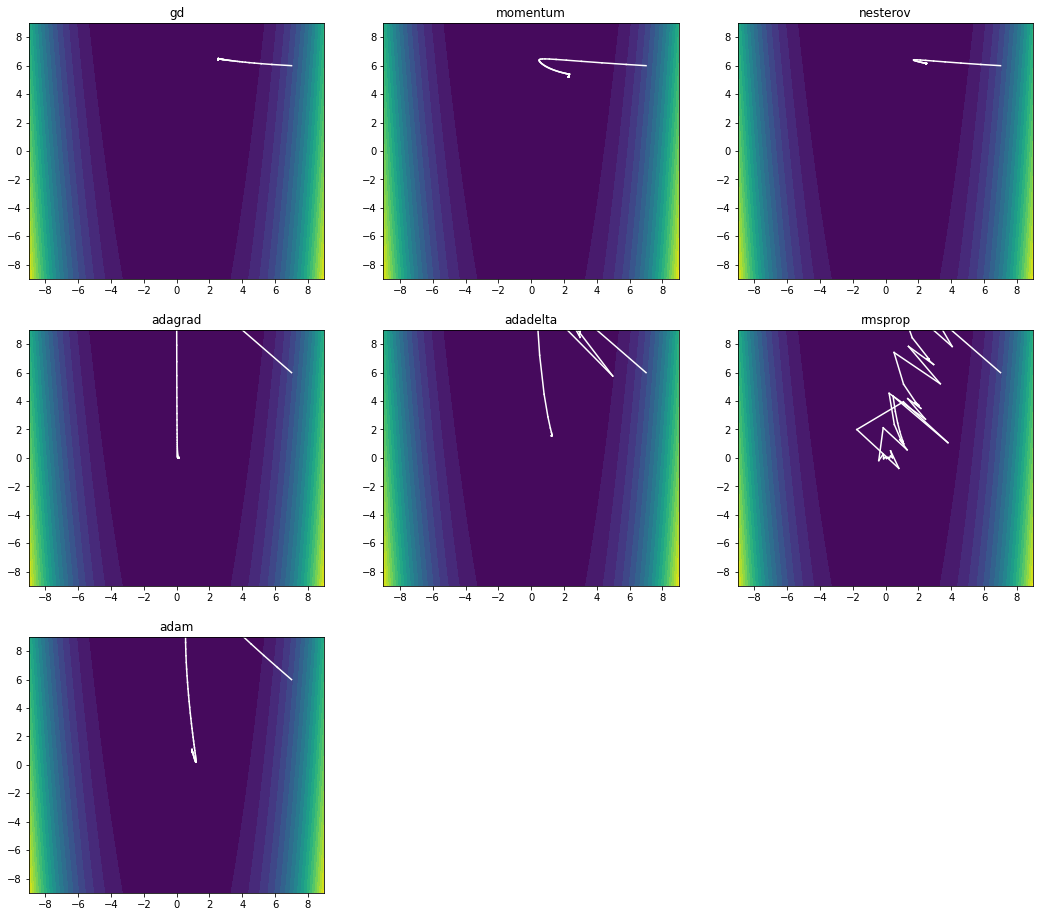

In [15]:
plt.figure(figsize=(18,16))
for i, results in enumerate([out_gd[1], out_momentum[1], out_nesterov[1],out_adagrad[1],out_adadelta[1],out_rmsprop[1],out_adam[1]], 1):
    plt.subplot(3, 3, i)
    contour(X,Y,Z,results)
    plt.title(titles[i-1])

In [16]:
def funVal_iterations(arr):
    arr = np.array(arr)
    value=[]
    iterations=[]
    for i in range(1,len(arr) - 1):
        value.append(Rosen(arr[i]))
        iterations.append(i)
    plt.plot(iterations,value)

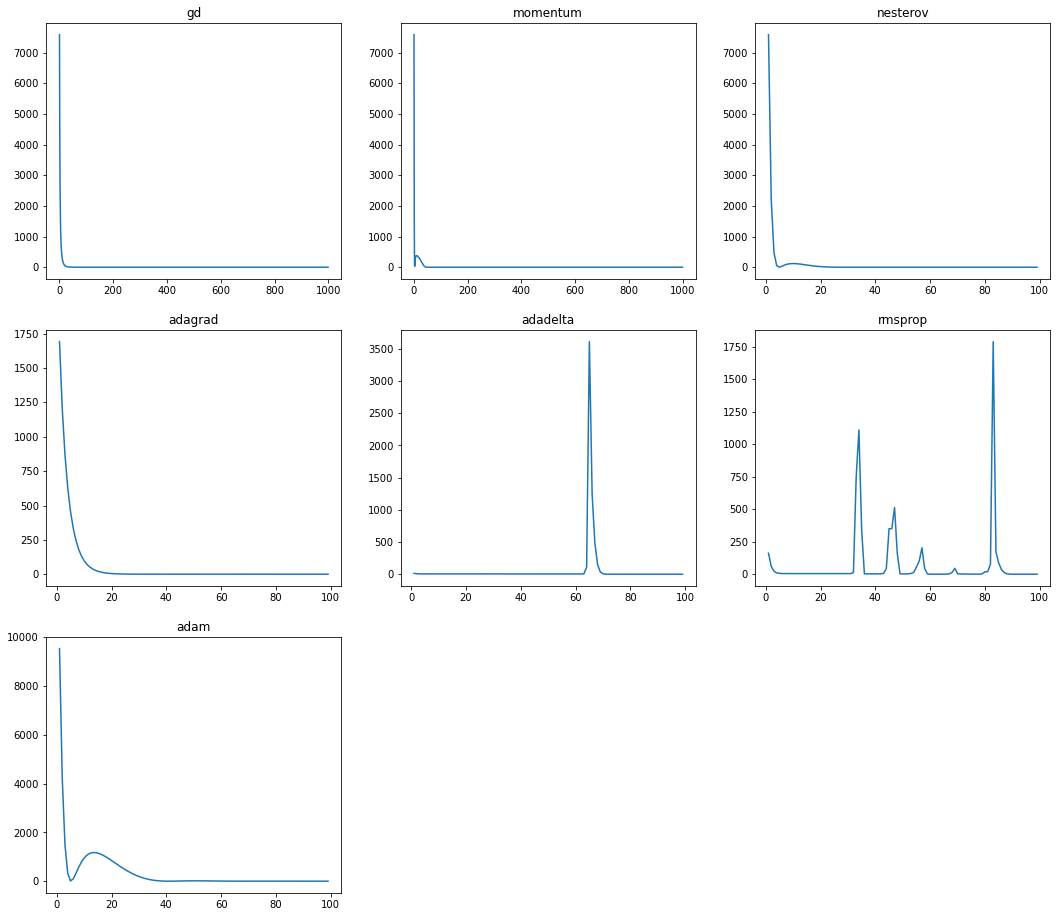

In [17]:
plt.figure(figsize=(18,16))
for i, results in enumerate([out_gd[1], out_momentum[1], out_nesterov[1],out_adagrad[1],out_adadelta[1],out_rmsprop[1],out_adam[1]], 1):
    plt.subplot(3, 3, i)
    funVal_iterations(results)
    plt.title(titles[i-1])

\begin{exercise}
Solve the least squares problem with quadratic polynomials given in online lab3 by applying the following gradient based methods and evaluate them with respect to accuracy achieved and the number of iterations required to achieve this accuracy. 

\end{exercise}


In [18]:
x = np.arange(10)
y = np.array([  1.58873597,   7.55101533,  10.71372171,   7.90123225,
                -2.05877605, -12.40257359, -28.64568712, -46.39822281,
                -68.15488905, -97.16032044])

X = np.c_[np.ones(len(x)), x,x**2]

def f(b,x=x,y=y):
    return (b[0] + b[1]*x + b[2]*x**2 - y)

def grad(b,x=X,y=y):
    return X.T@X@b- X.T@y

beta=np.array([5,6,7])
#gd(beta,0.01,grad(x,y,beta))
grad(beta)

array([  2542.0657638 ,  18043.9094954 , 136664.14427298])

In [19]:
out1= gd([5,6,7],0.0001,grad)
out2= momentum([5,6,7],0.0001,grad)
out3 = nesterov([5,6,7], 0.00001, grad)
out4 = adagrad([5,6,7], 12, grad)
out5 = adadelta([5,6,7], 4, grad)
out6 = rmsprop([5,6,7], 2, grad)
out7 = adam([5,6,7],grad, 50, 7, 0.8, 0.9)

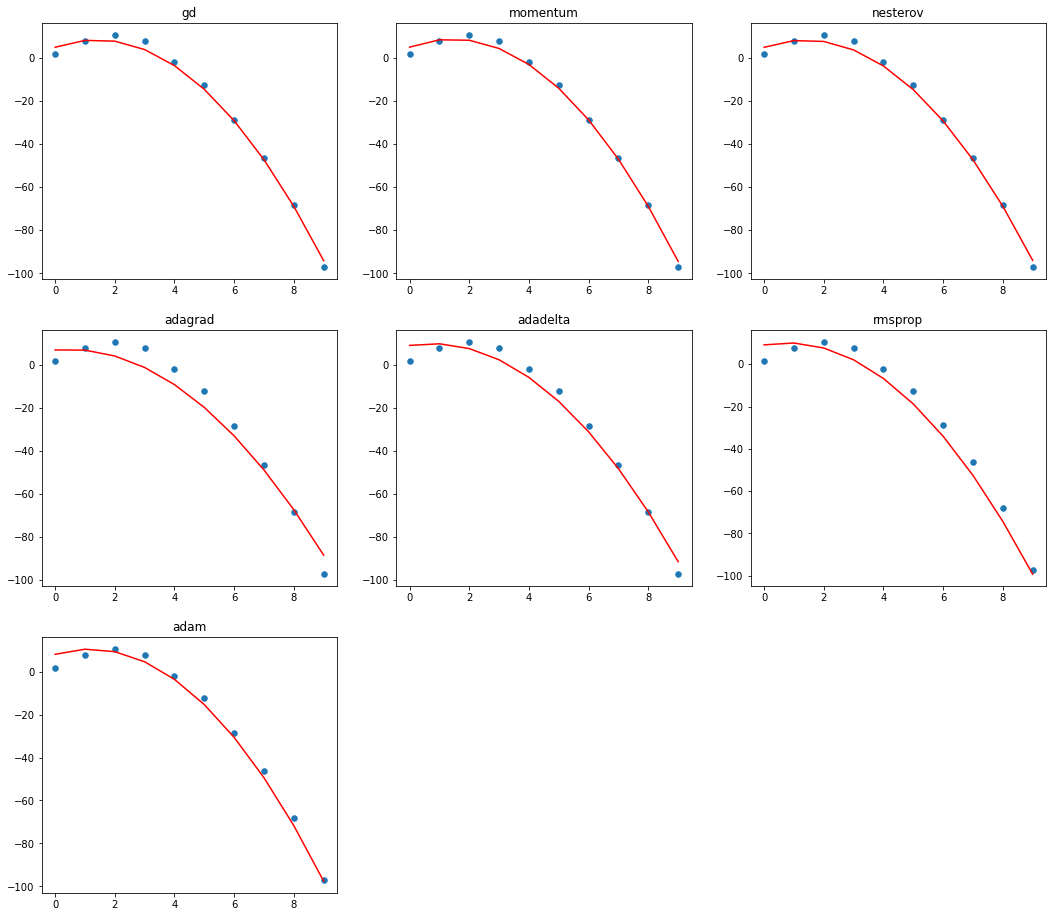

In [20]:
plt.figure(figsize=(18,16))
for i, beta in enumerate([out1[0], out2[0], out3[0],out4[0],out5[0],out6[0],out7[0]], 1):
    plt.subplot(3, 3, i)
    plt.scatter(x, y, s=30)
    plt.plot(x, beta[0] + beta[1]*x+beta[2]*x**2, color='red')
    plt.title(titles[i-1])

In [21]:
def LS_iterations(arr):
    arr = np.array(arr)
    value=[]
    iterations=[]
    for i in range(1,len(arr) - 1):
        value.append(f(arr[i]))
        iterations.append(i)
    plt.plot(iterations,value)

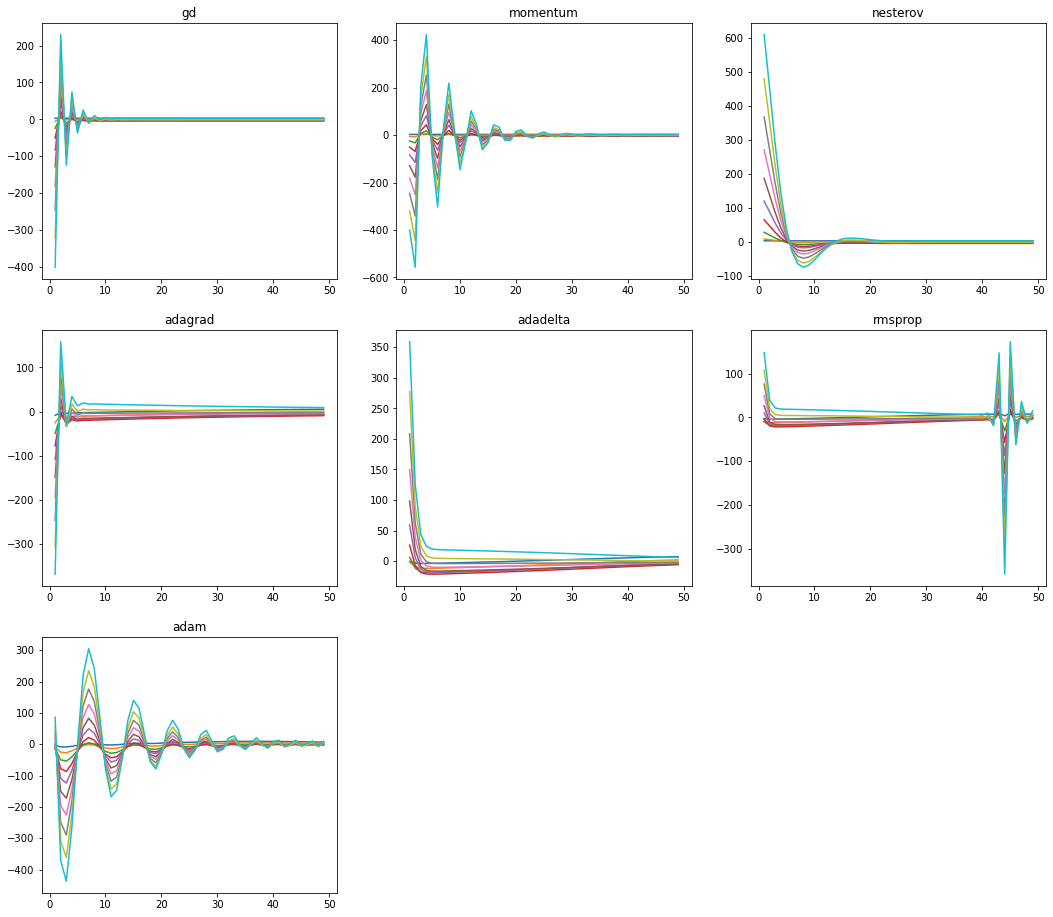

In [22]:
plt.figure(figsize=(18,16))
for i, results in enumerate([out1[1], out2[1], out3[1],out4[1],out5[1],out6[1],out7[1]], 1):
    plt.subplot(3, 3, i)
    LS_iterations(results)
    plt.title(titles[i-1])

The performance of the algorithms can be evaluated visually through the graphs above , however we can be more precise in your assessment by computing additional metrics such as the squared error and the R-squared to measure the 'goodness of fit'.

In [23]:
TSS=sum((y-np.mean(y))**2)
df = pd.DataFrame()
lst_dict = []
for i, results in enumerate([out1, out2, out3,out4,out5,out6,out7], 1):
    RSS=sum(f(results[0])**2)
    R=1-(RSS/TSS)
    lst_dict.append({'algorithm':titles[i-1], 'iterations': len(results[1])-1, ' Squared error': RSS,'R-squared': R})
df=df.append(lst_dict)
df.sort_values(['R-squared'],ascending=False).style.hide_index()

algorithm,iterations,Squared error,R-squared
momentum,50,44.290072,0.996398
gd,50,55.316458,0.995502
nesterov,50,59.805681,0.995137
adam,50,100.525090,0.991826
adadelta,50,180.280734,0.985340
rmsprop,50,278.932484,0.977318
adagrad,50,366.435217,0.970203


The performance of the algorithms in this particular problem and with these given parameters, is presented in order from the most accurate to least in the above dataframe. Those results are even more confirmed by the graphs. 